<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-data" data-toc-modified-id="Loading-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading data</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Feature Engineering</a></span></li><li><span><a href="#Cross-validation" data-toc-modified-id="Cross-validation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Cross validation</a></span></li><li><span><a href="#Submission" data-toc-modified-id="Submission-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Submission</a></span></li></ul></div>

In [1]:
%matplotlib inline

from tqdm.notebook import tqdm as tqdm
import sys
import pandas as pd
import numpy as np

import os
import gc

import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option("max_colwidth", -1)
pd.set_option("max_columns", 500)
pd.set_option("max_rows", 500)


plt.style.use('fivethirtyeight')
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

### Loading data

In [2]:
train = pd.read_csv("Train.csv", index_col=None)
print(train.shape)
train.head()

(1358, 16)


,grade_A_Component_1,grade_A_Component_2,max_luminosity,thickness,xmin,xmax,ymin,ymax,pixel_area,log_area,x_component_1,x_component_2,x_component_3,x_component_4,x_component_5,class
0,0,1,150,36,144,172,947225,947332,439,439.099273,0,0,1,0,0,1
1,1,0,134,55,1144,1152,2379058,2379624,329,329.205616,1,0,0,0,0,1
2,1,0,135,65,950,974,1038442,1036754,300,300.120598,0,0,0,0,0,2
3,0,1,123,35,41,220,1705580,1705604,6803,6803.778622,0,0,1,0,0,1
4,1,0,138,69,462,466,1088124,1086579,251,251.401943,0,0,0,0,0,2


In [3]:
target = 'class'
cat_cols = []
num_cols = [col for col in train.columns if col not in [target]+cat_cols]; num_cols

['grade_A_Component_1',
 'grade_A_Component_2',
 'max_luminosity',
 'thickness',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'pixel_area',
 'log_area',
 'x_component_1',
 'x_component_2',
 'x_component_3',
 'x_component_4',
 'x_component_5']

In [4]:
test = pd.read_csv("Test.csv", index_col=None)
print(test.shape)
test.head()

(583, 15)


,grade_A_Component_1,grade_A_Component_2,max_luminosity,thickness,xmin,xmax,ymin,ymax,pixel_area,log_area,x_component_1,x_component_2,x_component_3,x_component_4,x_component_5
0,1,0,123,65,33,54,1646439,1646893,632,632.391749,0,1,0,0,0
1,0,1,158,99,125,132,189874,189529,421,421.928609,0,0,0,0,0
2,0,1,120,35,64,75,12986873,12986862,272,272.212214,1,0,0,0,0
3,0,1,130,39,57,177,309634,310824,3312,3312.310581,0,0,1,0,0
4,1,0,142,75,23,79,5368307,5367467,862,862.499179,0,0,0,0,0


### Feature Engineering

In [5]:
def feature_engineering(df):
    # perform feature engineering here
    df['x_diff'] = df['xmax'] - df['xmin']
    df['max_luminosity_by_thickness'] = df['max_luminosity']/df['thickness']
    df['x_component_sum'] = df[component_cols].sum(axis=1)
    df['x_component_std'] = df[component_cols].std(axis=1)
    
    return df

In [6]:
component_cols = ['x_component_1',
'x_component_2',
'x_component_3',
'x_component_4',
'x_component_5']

train = feature_engineering(train)
test = feature_engineering(test)

### Cross validation

In [7]:
drop_cols = ['pixel_area']

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

preds = []

valid_score_list = []
cv = StratifiedKFold(n_splits=5) 
for i, (train_ind, test_ind) in enumerate(cv.split(train, train[target])):
    data_train = train.iloc[train_ind].reset_index(drop=True)
    data_valid = train.iloc[test_ind].reset_index(drop=True)
    data_test = test.reset_index(drop=True)
    
    clf = RandomForestClassifier(n_jobs=-1, n_estimators=3000, class_weight='balanced')
    X_train = data_train.drop([target]+drop_cols, axis=1)
    X_valid = data_valid.drop([target]+drop_cols, axis=1)
    X_test = data_test.drop(drop_cols, axis=1)

    clf.fit(X_train, 
            data_train[target],)
    
    valid_prediction = clf.predict_proba(X_valid)
    valid_score = log_loss(data_valid[target], valid_prediction)
    valid_score_list.append(valid_score)
    print("FOLD:{} Score:{:0.2f}".format(i+1, valid_score))
    
    preds.append(clf.predict_proba(X_test))
    
print("CV score is {}".format(np.mean(valid_score_list)))

FOLD:1 Score:0.27
FOLD:2 Score:0.27
FOLD:3 Score:0.27
FOLD:4 Score:0.27
FOLD:5 Score:0.29
CV score is 0.27512361258706985


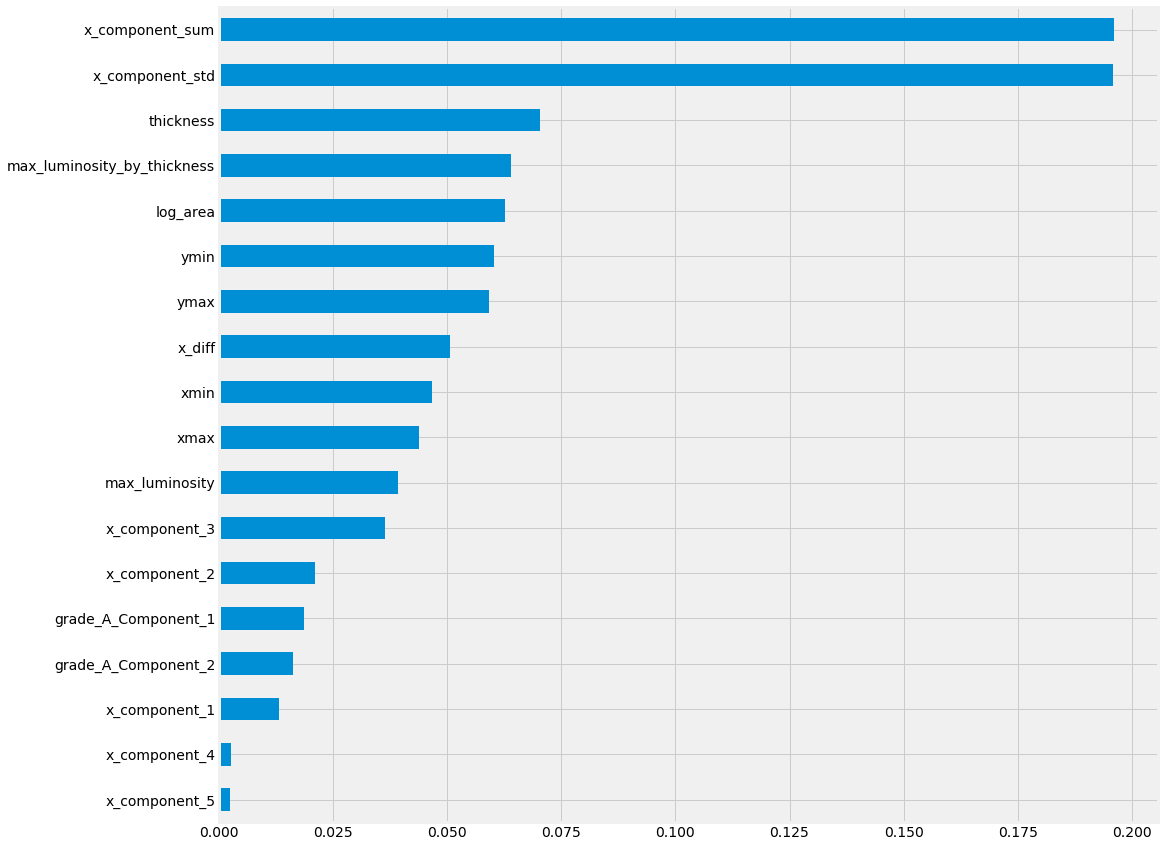

In [9]:
pd.Series(clf.feature_importances_, index=X_train.columns).sort_values().plot(kind='barh', figsize=(15,15))

### Submission

In [10]:
prediction = np.mean(preds, axis=0)

In [11]:
sub = pd.DataFrame(prediction, columns=[1,2])
sub.to_excel("model_rf_v3.xlsx", index=None)
sub.head()

,1,2
0,0.9998,0.0002
1,0.1368,0.8632
2,0.9962,0.0038
3,0.9962,0.0038
4,0.4897,0.5103
